# Vision Transformer (ViT) Model Evaluation

### Importing, testing, and evaluating two Vision Transformer (ViT) models developed in Keras and PyTorch

### 1. Importing necessary libaries 

In [11]:
import os 
import time
import random
import numpy as np
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

import torch
import torch.nn as nn
#import torch.optim as optim
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from torch.utils.data import  random_split
import torch.nn.functional as F

from sklearn.metrics import (accuracy_score,
                             precision_score,
                             recall_score,
                             f1_score,
                             roc_curve, 
                             roc_auc_score,
                             log_loss,
                             classification_report,
                             confusion_matrix,
                             ConfusionMatrixDisplay,
                            )
from sklearn.preprocessing import label_binarize


warnings.filterwarnings("ignore")
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
gpu_list = tf.config.list_physical_devices('GPU')
device = "gpu" if gpu_list != [] else "cpu"
print(f"TensorFlow {tf.__version__}  |  GPUs found: {tf.config.list_physical_devices('GPU')}")


TensorFlow 2.20.0  |  GPUs found: []


## 2. Model paths

In [12]:
keras_model_name = "keras_cnn_vit.model.keras"
keras_model_path = os.path.join(os.getcwd(), "..", "models", keras_model_name)

pytorch_state_dict_name = "pytorch_vit_model_state_dict.pth"
pytorch_state_dict_path = os.path.join(os.getcwd(), "..", "models", pytorch_state_dict_name)

if not os.path.exists(keras_model_path):
    print("Unable to find the Keras model at give path. Please check...")
else:
    print(f"Found the pre-trained Keras model:\n{keras_model_name} --at------> {keras_model_path}")

if not os.path.exists(pytorch_state_dict_path):
    print("Unable to find the PyTorch model at give path. Please check...")
else:
    print(f"Found the pre-trained PyTorch model:\n{pytorch_state_dict_name} --at------> {pytorch_state_dict_path}")

Found the pre-trained Keras model:
keras_cnn_vit.model.keras --at------> /home/ashmin/Projects/land-classification-using-deep-learning/notebooks/../models/keras_cnn_vit.model.keras
Found the pre-trained PyTorch model:
pytorch_vit_model_state_dict.pth --at------> /home/ashmin/Projects/land-classification-using-deep-learning/notebooks/../models/pytorch_vit_model_state_dict.pth


### 3.  Defining PyTorch model architecture
Defining the PyTorch CNN-ViT model architecture, exactly as defined during the model training,

In [13]:
#====================
class ConvNet(nn.Module):
    ''' 
    Class to define the architecture same as the imported pre-trained CNN model
    '''
    def __init__(self, num_classes: int):
        super().__init__()
        # -------- convolutional feature extractor --------
        self.features = nn.Sequential(
            nn.Conv2d(3, 32,  kernel_size=5, padding=2), nn.ReLU(inplace=True), nn.MaxPool2d(2), nn.BatchNorm2d(32),
            nn.Conv2d(32, 64,  kernel_size=5, padding=2), nn.ReLU(inplace=True), nn.MaxPool2d(2), nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, kernel_size=5, padding=2), nn.ReLU(inplace=True), nn.MaxPool2d(2), nn.BatchNorm2d(128),
            nn.Conv2d(128, 256, kernel_size=5, padding=2), nn.ReLU(inplace=True), nn.MaxPool2d(2), nn.BatchNorm2d(256),
            nn.Conv2d(256, 512, kernel_size=5, padding=2), nn.ReLU(inplace=True), nn.MaxPool2d(2), nn.BatchNorm2d(512),
            nn.Conv2d(512, 1024, kernel_size=5, padding=2), nn.ReLU(inplace=True), nn.MaxPool2d(2), nn.BatchNorm2d(1024),
        )

        # -------- global pooling + classifier head --------
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(nn.Flatten(),                           # flatten feature map of dimensions (1024 × 1 × 1) to 1024
                                        nn.Linear(1024, 2048), nn.ReLU(inplace=True), nn.BatchNorm1d(2048), nn.Dropout(0.4), 
                                        nn.Linear(2048, num_classes)
                                       )

    def forward_features(self, x: torch.Tensor) -> torch.Tensor:
        return self.features(x)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.forward_features(x)   # features, dimensions:(B, 1024, H', W')
        x = self.pool(x)               # global-average-pooling, dimensions: (B, 1024, 1, 1)
        x = self.classifier(x)         # classifier, dimensions: (B, num_classes)
        return x

#====================
class PatchEmbed(nn.Module):
    def __init__(self, input_channel=1024, embed_dim=768):
        super().__init__()
        self.proj = nn.Conv2d(input_channel, embed_dim, kernel_size=1)  # 1×1 conv
    
    def forward(self, x):
        x = self.proj(x).flatten(2).transpose(1, 2)  # (B,L,D)
        return x

#====================
class MHSA(nn.Module):
    def __init__(self, dim, heads=8, dropout=0.):
        super().__init__()
        self.heads = heads
        self.scale = (dim // heads) ** -0.5
        self.qkv = nn.Linear(dim, dim * 3)
        self.attn_drop = nn.Dropout(dropout)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(dropout)
    
    def forward(self, x):
        B, N, D = x.shape
        q, k, v = self.qkv(x).chunk(3, dim=-1)
        q = q.reshape(B, N, self.heads, -1).transpose(1, 2)  # (B, heads, N, d)
        k = k.reshape(B, N, self.heads, -1).transpose(1, 2)
        v = v.reshape(B, N, self.heads, -1).transpose(1, 2)
        attn = torch.matmul(q, k.transpose(-2, -1)) * self.scale
        attn = self.attn_drop(attn.softmax(dim=-1))
        x = torch.matmul(attn, v).transpose(1, 2).reshape(B, N, D)
        return self.proj_drop(self.proj(x))

#====================
class TransformerBlock(nn.Module):
    def __init__(self, dim, heads, mlp_ratio=4., dropout=0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn  = MHSA(dim, heads, dropout)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp   = nn.Sequential(
                                    nn.Linear(dim, int(dim * mlp_ratio)),
                                    nn.GELU(), nn.Dropout(dropout),
                                    nn.Linear(int(dim * mlp_ratio), dim),
                                    nn.Dropout(dropout))
    
    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

#====================
class ViT(nn.Module):
    def __init__(self, in_ch=1024, num_classes=2,
                 embed_dim=768, depth=6, heads=8,
                 mlp_ratio=4., dropout=0.1, max_tokens=50):
        super().__init__()
        self.patch = PatchEmbed(in_ch, embed_dim)           # 1×1 conv
        self.cls   = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos   = nn.Parameter(torch.randn(1, max_tokens, embed_dim))
        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, heads, mlp_ratio, dropout)
            for _ in range(depth)])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):                          # x: (B,C,H,W)
        x = self.patch(x)                          # (B,L,D)
        B, L, _ = x.shape
        cls = self.cls.expand(B, -1, -1)           # (B,1,D)
        x = torch.cat((cls, x), 1)                 # (B,L+1,D)
        x = x + self.pos[:, :L + 1]                # match seq-len
        for blk in self.blocks:
            x = blk(x)
        return self.head(self.norm(x)[:, 0])       # CLS token

#====================
class CNN_ViT_Hybrid(nn.Module):
    def __init__(self, num_classes=2, embed_dim=768, depth=6, heads=8):
        super().__init__()
        self.cnn = ConvNet(num_classes)            # load weights later
        self.vit = ViT(num_classes=num_classes,
                       embed_dim=embed_dim,
                       depth=depth,
                       heads=heads)
    
    def forward(self, x):
        return self.vit(self.cnn.forward_features(x))

#====================
def evaluate(model, loader, criterion, device):
    with torch.no_grad():
        model.eval()
        loss_sum, correct = 0, 0
        for batch_idx, (x, y) in enumerate(tqdm(loader, desc="Validation")):
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            loss_sum += loss.item() * x.size(0)
            correct  += (out.argmax(1) == y).sum().item()
    return loss_sum / len(loader.dataset), correct / len(loader.dataset)# Set device

### 4. Dataset path and hyperparameters

In [14]:
dataset_path = os.path.join(os.getcwd(), "..", "data", "images_dataSAT")

# hyperparameters common dataloader
img_w, img_h = 64, 64
batch_size = 128
num_classes = 2
agri_class_labels = ["non-agri", "agri"]

# hyperparameters for PyTorch CNN-Vit Hybrid model
depth = 3
attn_heads = 6
embed_dim = 768

### 5. PyTorch Dataloader

In [15]:
train_transform = transforms.Compose([
    transforms.Resize((img_w, img_h)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
full_dataset = datasets.ImageFolder(dataset_path, transform=train_transform)
test_loader = DataLoader(full_dataset, batch_size=batch_size, shuffle=False)

### 6. Pytorch model creation and loading

In [16]:
# Check device availability
device = "cuda" if torch.cuda.is_available() else "cpu"

# Create model instance
pytorch_model = CNN_ViT_Hybrid(num_classes=num_classes,
                      heads=attn_heads,
                      depth=depth,
                      embed_dim=embed_dim).to(device)

# Load pre-trained CNN-ViT hybrid model weights 
if device=="cpu":
    map_location=torch.device("cpu")
else:
    map_location=torch.device("cuda")

pytorch_model.load_state_dict(torch.load(pytorch_state_dict_path, map_location=map_location), strict=False)
print("Loaded model state dict, now getting predictions")

Loaded model state dict, now getting predictions


### 7. PyTorch model evaluation

In [17]:
all_preds_pytorch = []
all_labels_pytorch = []
all_probs_pytorch = []

pytorch_model.eval()
with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(tqdm(test_loader, desc="Step")):
#    for images, labels in test_loader:
        images = images.to(device)
        outputs = pytorch_model(images)
        preds = torch.argmax(outputs, dim=1)
        probs = F.softmax(outputs, dim=1)[:, 1]  # probability for class 1
        all_probs_pytorch.extend(probs.cpu())
        all_preds_pytorch.extend(preds.cpu().numpy().flatten())
        all_labels_pytorch.extend(labels.numpy())

Step:   0%|          | 0/47 [00:00<?, ?it/s]

Step: 100%|██████████| 47/47 [00:20<00:00,  2.31it/s]


### 8.  Keras model loading

In [18]:
# Positional embedding that Keras can track
@tf.keras.utils.register_keras_serializable(package="Custom")
class AddPositionEmbedding(layers.Layer):
    def __init__(self, num_patches, embed_dim, **kwargs):
        super(AddPositionEmbedding, self).__init__(**kwargs)
        self.num_patches = num_patches
        self.embed_dim   = embed_dim
        self.pos = self.add_weight(
            name="pos_embedding",
            shape=(1, num_patches, embed_dim),
            initializer="random_normal",
            trainable=True)

    def call(self, tokens):
        return tokens + self.pos

    def get_config(self):
        config = super().get_config()
        config.update({
            "num_patches": self.num_patches,
            "embed_dim":   self.embed_dim,
        })
        return {**config}

# One Transformer encoder block
@tf.keras.utils.register_keras_serializable(package="Custom")
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads=8, mlp_dim=2048, dropout=0.1, **kwargs):
        super(TransformerBlock, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.mlp_dim   = mlp_dim
        self.dropout   = dropout
        self.mha  = layers.MultiHeadAttention(num_heads, key_dim=embed_dim)
        self.norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.norm2 = layers.LayerNormalization(epsilon=1e-6)
        self.mlp = tf.keras.Sequential([
            layers.Dense(mlp_dim, activation="gelu"),
            layers.Dropout(dropout),
            layers.Dense(embed_dim),
            layers.Dropout(dropout)
        ])

    def call(self, x):
        x = self.norm1(x + self.mha(x, x))
        return self.norm2(x + self.mlp(x))

    # ---- NEW ----
    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim":  self.embed_dim,
            "num_heads":  self.num_heads,
            "mlp_dim":    self.mlp_dim,
            "dropout":    self.dropout,
        })
        return {**config}
    


# ------------------- load CNN-ViT hybrid model ------------------
keras_model = load_model(keras_model_path,
                         custom_objects={
                         "AddPositionEmbedding": AddPositionEmbedding,
                         "TransformerBlock":     TransformerBlock
                          })

## 9. Keras Dataloader

In [19]:
datagen = ImageDataGenerator(rescale=1./255)
prediction_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(img_w, img_h),
    batch_size=batch_size,
    class_mode="binary",
    shuffle=False
)

Found 6000 images belonging to 2 classes.


### 10. Keres Model evaluation

In [20]:
all_probs_keras = keras_model.predict(prediction_generator, verbose=1)
all_preds_keras = np.argmax(all_probs_keras, axis=1)
all_labels_keras = prediction_generator.classes



# define a function to get the metrics comprehensively
def model_metrics(y_true, y_pred, y_prob, class_labels):
    y_prob = np.array(y_prob)
    if len(y_prob.shape)<2:
        roc_score = roc_auc_score(y_true, y_prob)
    elif len(y_prob.shape)==2:
        roc_score = roc_auc_score(y_true, y_prob[:,1])
    else:
        roc_score = np.nan
    metrics = {'Accuracy': accuracy_score(y_true, y_pred),
               'Precision': precision_score(y_true, y_pred),
               'Recall': recall_score(y_true, y_pred),
               'Loss': log_loss(y_true, y_prob),
               'F1 Score': f1_score(y_true, y_pred),
               'ROC-AUC': roc_score,
               'Confusion Matrix': confusion_matrix(y_true, y_pred),
               'Classification Report': classification_report(y_true, y_pred, target_names=class_labels, digits=4),
               "Class labels": class_labels
              }
    return metrics

#function to print the metrics
def print_metrics(y_true, y_pred, y_prob, class_labels, model_name):
    metrics = model_metrics(y_true, y_pred, y_prob, class_labels)
    
    print(f"Evaluation metrics for the \033[1m{model_name}\033[0m")
    print(f"Accuracy: {'':<1}{metrics["Accuracy"]:.4f}")
    if metrics["ROC-AUC"] != np.nan:
        print(f"ROC-AUC: {'':<2}{metrics["ROC-AUC"]:.4f}")
    print(f"Loss: {'':<5}{metrics["Loss"]:.4f}\n")
    print(f"Classification report:\n\n  {metrics["Classification Report"]}")
    print("========= Confusion Matrix =========")
    disp = ConfusionMatrixDisplay(confusion_matrix=metrics["Confusion Matrix"],
                                  display_labels=metrics["Class labels"])

    disp.plot()
    plt.show()


47/47 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step


### 10. Keras metrics reporting

Evaluation metrics for the Keras CNN-Vit Hybrid Model
Accuracy:  0.9960
ROC-AUC:   0.9921
Loss:      0.0638

Classification report:

                precision    recall  f1-score   support

    non-agri     0.9921    1.0000    0.9960      3000
        agri     1.0000    0.9920    0.9960      3000

    accuracy                         0.9960      6000
   macro avg     0.9960    0.9960    0.9960      6000
weighted avg     0.9960    0.9960    0.9960      6000

========= Confusion Matrix =========


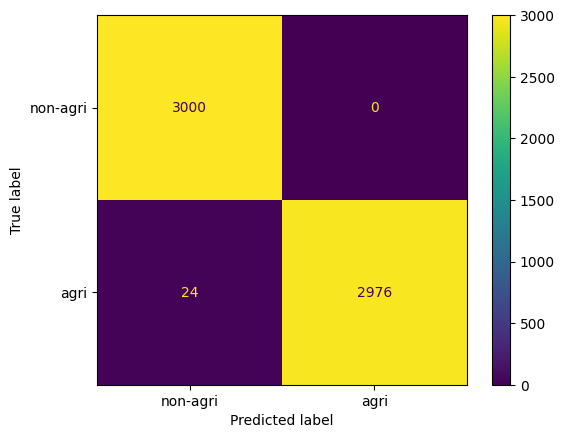

In [21]:
print_metrics(y_true = all_labels_keras,
              y_pred = all_preds_keras,
              y_prob = all_probs_keras,
              class_labels = agri_class_labels,
              model_name = "Keras CNN-Vit Hybrid Model"
             )

### 11. PyTorch metrics reporting

Evaluation metrics for the PyTorch CNN-Vit Hybrid Model
Accuracy:  0.9955
ROC-AUC:   0.9999
Loss:      0.0183

Classification report:

                precision    recall  f1-score   support

    non-agri     0.9967    0.9943    0.9955      3000
        agri     0.9943    0.9967    0.9955      3000

    accuracy                         0.9955      6000
   macro avg     0.9955    0.9955    0.9955      6000
weighted avg     0.9955    0.9955    0.9955      6000

========= Confusion Matrix =========


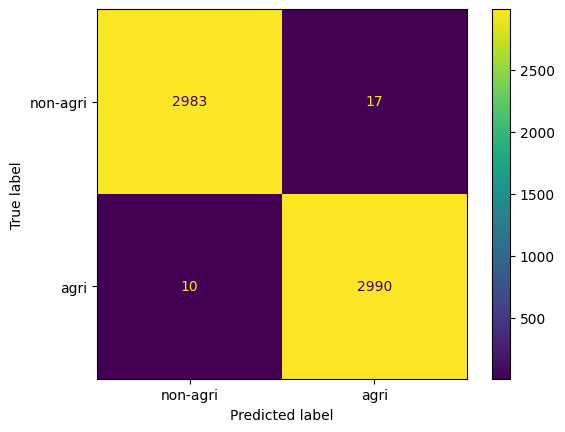

In [22]:
print_metrics(y_true = all_labels_pytorch,
              y_pred = all_preds_pytorch,
              y_prob = np.array(all_probs_pytorch),
              class_labels = agri_class_labels,
              model_name = "PyTorch CNN-Vit Hybrid Model"
             )

### 12.  ROC curve plotting

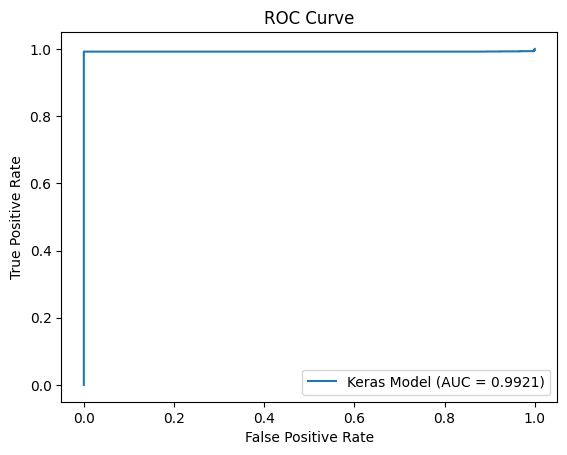

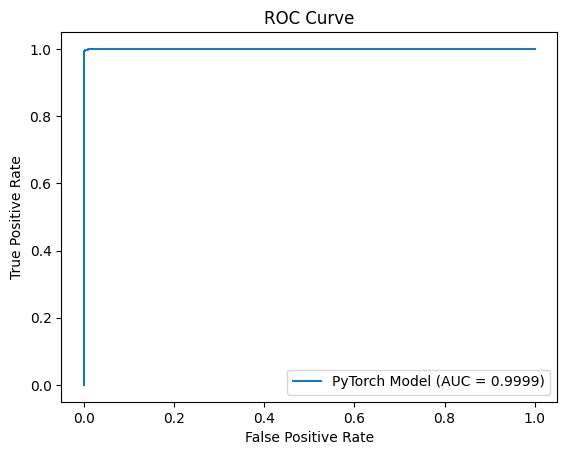

In [23]:

def plot_roc(y_true, y_prob, model_name):
    n_classes = y_prob.shape[1] if y_prob.ndim > 1 else 1
    if n_classes == 1:
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        auc = roc_auc_score(y_true, y_prob)
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.4f})')
    else:
        y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
            auc = roc_auc_score(y_true_bin[:, i], y_prob[:, i])
            plt.plot(fpr, tpr, label=f'{model_name} class {i} (AUC = {auc:.4f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()


plot_roc(np.array(all_labels_keras), np.array(all_probs_keras[:, 1]), "Keras Model")
plt.show()
plot_roc(np.array(all_labels_pytorch), np.array(all_probs_pytorch), "PyTorch Model")
plt.show()

# Comparing model performance

In [24]:
# get the Keras model performance metrics
metrics_keras = model_metrics(all_labels_keras, all_preds_keras, all_probs_keras, agri_class_labels)

# get the PyTorch model performance metrics
metrics_pytorch = model_metrics(all_labels_pytorch, all_preds_pytorch, all_probs_pytorch, agri_class_labels)


# Display the comparison of metrics
print("{:<18} | {:<15} {:<15}".format('\033[1m'+ 'Metric' + '\033[0m',
                                    'Keras Model', 
                                    'PyTorch Model'))
print(("".join(["-" for _ in range(43)])))
metrics_list = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC']

for k in metrics_list:
    print("{:<18} | {:<15.4f} {:<15.4f}".format('\033[1m'+k+'\033[0m',
                                              metrics_keras[k],
                                              metrics_pytorch[k]))

Metric     | Keras Model     PyTorch Model  
-------------------------------------------
Accuracy   | 0.9960          0.9955         
Precision  | 1.0000          0.9943         
Recall     | 0.9920          0.9967         
F1 Score   | 0.9960          0.9955         
ROC-AUC    | 0.9921          0.9999         
